##IMPORT LIBRARIES

In [ ]:
from pathlib import Path
import numpy as np
import math
from itertools import groupby
import h5py
import numpy as np
import unicodedata
import cv2
import torch
from torch import nn
from torchvision.models import resnet50, resnet101
from torch.autograd import Variable
import torchvision
from data import preproc as pp
from data import evaluation
from torch.utils.data import Dataset
import time

ModuleNotFoundError: No module named 'data'

#OCR MODEL

OCR model implementation in PyTorch with ResNet-101 and Transformer networks


#ResNet-101 backbone:

This is a convolutional neural network used to extract features from the input image.
Conversion layer: this is a convolutional layer that converts the feature maps produced by the ResNet-101 backbone to a lower-dimensional representation that can be input to the transformer.

#Positional Encoding:

The result module generates a tensor of positional encodings for the transformer model. This tensor contains information about the position of each token in the input sequence.

The positional encodings are generated using a combination of sine and cosine functions.

#CNN:

The CNN is used to extract features from the input image and reduce its dimensions, while the transformer is used to generate the output sequence of characters.




In [ ]:

class result(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=128):
        super(result, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        data = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        data[:, 0::2] = torch.sin(position * div_term)
        data[:, 1::2] = torch.cos(position * div_term)
        data = data.unsqueeze(0).transpose(0, 1)
        self.register_buffer('data', data)

    def forward(self, x):
        x = x + self.data[:x.size(0), :]
        return self.dropout(x)


class OCR(nn.Module):

    def __init__(self, vocab_len, hidden_dim, nheads,
                 num_encoder_layers, num_decoder_layers):
        super().__init__()

        # create ResNet-101 backbone
        self.backbone = resnet101()
        del self.backbone.fc

        # create conversion layer
        self.conv = nn.Conv2d(2048, hidden_dim, 1)

        # create a default PyTorch transformer
        self.transformer = nn.Transformer(
            hidden_dim, nheads, num_encoder_layers, num_decoder_layers)

        # prediction heads with length of vocab

        self.vocab = nn.Linear(hidden_dim,vocab_len)

        # output positional encodings (object queries)
        self.decoder = nn.Embedding(vocab_len, hidden_dim)
        self.query_pos = result(hidden_dim, .2)

        # spatial positional encodings, sine positional encoding can be used.
        self.row_embed = nn.Parameter(torch.rand(50, hidden_dim // 2))
        self.col_embed = nn.Parameter(torch.rand(50, hidden_dim // 2))
        self.trg_mask = None

    def position(self, sz):
        A = torch.triu(torch.ones(sz, sz), 1)
        A = A.masked_fill(A==1, float('-inf'))
        return A

    def get_feature(self,x):
        x = self.backbone.conv1(x)
        x = self.backbone.bn1(x)
        x = self.backbone.relu(x)
        x = self.backbone.maxpool(x)

        x = self.backbone.layer1(x)
        x = self.backbone.layer2(x)
        x = self.backbone.layer3(x)
        x = self.backbone.layer4(x)
        return x


    def length(self, inp):
        return (inp == 0).transpose(0, 1)


    def forward(self, inputs, C):
        # propagate inputs through ResNet-101 up to avg-pool layer
        x = self.get_feature(inputs)

        # convert from 2048 to 256 feature planes for the transformer
        h = self.conv(x)

        # construct positional encodings
        bs,_,H, W = h.shape
        pos = torch.cat([
            self.col_embed[:W].unsqueeze(0).repeat(H, 1, 1),
            self.row_embed[:H].unsqueeze(1).repeat(1, W, 1),
        ], dim=-1).flatten(0, 1).unsqueeze(1)

        # generating subsequent mask for target
        if self.trg_mask is None or self.trg_mask.size(0) != len(C):
            self.trg_mask = self.position(C.shape[1]).to(C.device)

        # Padding mask
        B = self.length(C)

        # Getting postional encoding for target
        C = self.decoder(C)
        C = self.query_pos(C)

        output = self.transformer(pos + 0.1 * h.flatten(2).permute(2, 0, 1), C.permute(1,0,2), tgt_mask=self.trg_mask,
                                  tgt_key_padding_mask=B.permute(1,0))

        return self.vocab(output.transpose(0,1))


def make_model(vocab_len, hidden_dim=256, nheads=4,
                 num_encoder_layers=4, num_decoder_layers=4):

    return OCR(vocab_len, hidden_dim, nheads,
                 num_encoder_layers, num_decoder_layers)

#ENCODING AND DECODING

Using the Tokenizer class for text encoding and decoding, this dataset contains both text and image data.

#Mask:


The masks help the model focus on relevant information and ignore irrelevant information during training.

#Tokens:

We add some Token to understand the machine and perform some task.


In [ ]:


class DataGenerator(Dataset):


    def __init__(self, source,charset, max_text_length, split, transform):
        self.tokenizer = Tokenizer(charset, max_text_length)
        self.transform = transform

        self.split = split
        self.dataset = dict()

        with h5py.File(source, "r") as f:
            self.dataset[self.split] = dict()

            self.dataset[self.split]['dt'] = np.array(f[self.split]['dt'])
            self.dataset[self.split]['gt'] = np.array(f[self.split]['gt'])

            randomize = np.arange(len(self.dataset[self.split]['gt']))
            np.random.seed(42)
            np.random.shuffle(randomize)

            self.dataset[self.split]['dt'] = self.dataset[self.split]['dt'][randomize]
            self.dataset[self.split]['gt'] = self.dataset[self.split]['gt'][randomize]

            # decode sentences from byte
            self.dataset[self.split]['gt'] = [x.decode() for x in self.dataset[self.split]['gt']]

        self.size = len(self.dataset[self.split]['gt'])


    def __getitem__(self, i):
        img = self.dataset[self.split]['dt'][i]

        #making image compatible with resnet
        img = np.repeat(img[..., np.newaxis],3, -1)
        img = pp.normalization(img)

        if self.transform is not None:
            img = self.transform(img)

        y_train = self.tokenizer.encode(self.dataset[self.split]['gt'][i])

        #padding till max length
        y_train = np.pad(y_train, (0, self.tokenizer.maxlen - len(y_train)))

        gt = torch.Tensor(y_train)

        return img, gt

    def __len__(self):
      return self.size



class Tokenizer():
    """Manager tokens functions and charset/dictionary properties"""

    def __init__(self, chars, max_text_length=128):
        self.PAD_TK, self.UNK_TK,self.SOS,self.EOS = "¶", "¤", "SOS", "EOS"
        self.chars = [self.PAD_TK] + [self.UNK_TK ]+ [self.SOS] + [self.EOS] +list(chars)
        self.PAD = self.chars.index(self.PAD_TK)
        self.UNK = self.chars.index(self.UNK_TK)

        self.vocab_size = len(self.chars)
        self.maxlen = max_text_length

    def encode(self, text):
        """Encode text to vector"""

        text = unicodedata.normalize("NFKD", text).encode("ASCII", "ignore").decode("ASCII")
        text = " ".join(text.split())

        groups = ["".join(group) for _, group in groupby(text)]
        text = "".join([self.UNK_TK.join(list(x)) if len(x) > 1 else x for x in groups])
        encoded = []

        text = ['SOS'] + list(text) + ['EOS']
        for item in text:
            index = self.chars.index(item)
            index = self.UNK if index == -1 else index
            encoded.append(index)

        return np.asarray(encoded)

    def decode(self, text):
        """Decode vector to text"""

        decoded = "".join([self.chars[int(x)] for x in text if x > -1])
        decoded = self.remove_tokens(decoded)
        decoded = pp.text_standardize(decoded)

        return decoded

    def remove_tokens(self, text):
        """Remove tokens (PAD) from text"""

        return text.replace(self.PAD_TK, "").replace(self.UNK_TK, "")



#DOWNLOAD IMAGE DATASET

Dataset name:Bentham dataset
This command-line programme downloads a file from Google Drive called "bentham.hdf5" Wget is used to download the file, and a cookie file is used to get the download link. This script's objective is to download the handwriting recognition dataset.



In [ ]:
#bentham data set download link

!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1-PqlAml3vKzWknITlC3jaoFNu5rKyFbr' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1-PqlAml3vKzWknITlC3jaoFNu5rKyFbr" -O bentham.hdf5 && rm -rf /tmp/cookies.txt


#FIND PATH

In [ ]:
!pwd

In [ ]:
import os
import datetime
import string

batch_size = 16
epochs = 200

# define paths
#change paths accordingly
source = 'bentham'
source_path = '/content/Transformer-ocr/src/Transformer-ocr/src/{}.hdf5'.format(source)
output_path = os.path.join("..", "output", source)
target_path = os.path.join(output_path, "checkpoint_weights_iam.hdf5")
os.makedirs(output_path, exist_ok=True)

# define input size, number max of chars per line and list of valid chars
input_size = (1024, 128, 1)
max_text_length = 128
charset_base = string.printable[:95]

print("source:", source_path)
print("output", output_path)
print("target", target_path)
print("charset:", charset_base)

In [ ]:
import torchvision.transforms as T

device = torch.device("cuda")
transform = T.Compose([
    T.ToTensor()])
tokenizer = Tokenizer(charset_base)

train_loader = torch.utils.data.DataLoader(DataGenerator(source_path,charset_base,max_text_length,'train',transform), batch_size=batch_size, shuffle=False, num_workers=2)
val_loader = torch.utils.data.DataLoader(DataGenerator(source_path,charset_base,max_text_length,'valid',transform), batch_size=batch_size, shuffle=False, num_workers=2)


In [ ]:
model = make_model(vocab_len=tokenizer.vocab_size)
_=model.to(device)

#LABEL SMOOTHING

Label smoothing is a technique used in machine learning to prevent a neural network from becoming overconfident in its predictions. It involves replacing the hard target labels (e.g., 0 or 1) with a smoothed distribution over all the possible labels. This encourages the model to learn more generalizable features and can improve its performance on unseen data.


In [ ]:
class label(nn.Module):
    "Implement label smoothing."
    def __init__(self, size, padding_idx=0, smoothing=0.0):
        super(label, self).__init__()
        self.find = nn.KLDivLoss(size_average=False)
        self.padding_idx = padding_idx
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.size = size
        self.true_dist = None

    def forward(self, x, target):
        assert x.size(1) == self.size
        true_dist = x.data.clone()
        true_dist.fill_(self.smoothing / (self.size - 2))
        true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)
        true_dist[:, self.padding_idx] = 0
        A = torch.nonzero(target.data == self.padding_idx)
        if A.dim() > 0:
            true_dist.index_fill_(0, A.squeeze(), 0.0)
        self.true_dist = true_dist
        return self.find(x, Variable(true_dist, requires_grad=False))


#Initializing training parameters for a language model.

In [ ]:
find = label(size=tokenizer.vocab_size, padding_idx=0, smoothing=0.1)
find.to(device)
lr = .0001 # learning rate
optimizer = torch.optim.AdamW(model.parameters(), lr=lr,weight_decay=.0004)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1, gamma=0.95)


#TRAINING AND EVALUATION

The **train function** executes the training on the supplied data using the model, optimizer, scheduler, and data loader as inputs. Gradient clipping is used to prevent gradient explosion while the Kullback-Leibler Divergence loss (KLDivLoss) with label smoothing is used to calculate the loss. The average loss per batch is returned.


The evaluate function evaluates the supplied data after receiving the model and data loader as inputs. It determines the loss by applying label smoothing to the KLDivLoss and returns the average loss per batch.




In [ ]:
def train(model, find, optimiser, scheduler,dataloader):

    model.train()
    total_loss = 0
    for batch, (imgs, labels_y,) in enumerate(dataloader):
          imgs = imgs.to(device)
          labels_y = labels_y.to(device)

          optimiser.zero_grad()
          output = model(imgs.float(),labels_y.long()[:,:-1])

          norm = (labels_y != 0).sum()
          loss = find(output.log_softmax(-1).contiguous().view(-1, tokenizer.vocab_size), labels_y[:,1:].contiguous().view(-1).long()) / norm

          loss.backward()
          torch.nn.utils.clip_grad_norm_(model.parameters(), 0.2)
          optimizer.step()
          total_loss += loss.item() * norm

    return total_loss / len(dataloader)

def evaluate(model, find, dataloader,):

    model.eval()
    epoch_loss = 0

    with torch.no_grad():
      for batch, (imgs, labels_y,) in enumerate(dataloader):
            imgs = imgs.to(device)
            labels_y = labels_y.to(device)

            output = model(imgs.float(),labels_y.long()[:,:-1])

            norm = (labels_y != 0).sum()
            loss = find(output.log_softmax(-1).contiguous().view(-1, tokenizer.vocab_size), labels_y[:,1:].contiguous().view(-1).long()) / norm

            epoch_loss += loss.item() * norm

    return epoch_loss / len(dataloader)

#TRAIN THE MODEL

In [ ]:
#train model

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

best_valid_loss = np.inf
c = 0
for epoch in range(10):

    print(f'Epoch: {epoch+1:02}','learning rate{}'.format(scheduler.get_last_lr()))

    start_time = time.time()

    train_loss = train(model,find, optimizer, scheduler, train_loader)
    valid_loss = evaluate(model, find, val_loader)

    epoch_mins, epoch_secs = epoch_time(start_time, time.time())

    c+=1
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), target_path)
        c=0

    if c>4:
        #decrease lr if loss does not deacrease after 5 steps
        scheduler.step()
        c=0

    print(f'Time: {epoch_mins}m {epoch_secs}s')
    print(f'Train Loss: {train_loss:.3f}')
    print(f'Val   Loss: {valid_loss:.3f}')

You can download the trained model and run inference on it.
Below link downloads the model. Once model is downloaded you can move it to your google storage.

###Function for generating memory from input images using a convolutional neural network and a transformer encoder.

In [ ]:
def get_memory(model,imgs):
    x = model.conv(model.get_feature(imgs))
    bs,_,H, W = x.shape
    pos = torch.cat([
            model.col_embed[:W].unsqueeze(0).repeat(H, 1, 1),
            model.row_embed[:H].unsqueeze(1).repeat(1, W, 1),
        ], dim=-1).flatten(0, 1).unsqueeze(1)

    return model.transformer.encoder(pos +  0.1 * x.flatten(2).permute(2, 0, 1))


##PREDICT THE DATASET

In [ ]:
def test(model, test_loader, max_text_length):
    model.eval()
    predicts = []
    gt = []
    imgs = []
    with torch.no_grad():
        for batch in test_loader:
            src, C = batch
            imgs.append(src.flatten(0,1))
            src, C = src.cuda(), C.cuda()
            memory = get_memory(model,src.float())
            out_indexes = [tokenizer.chars.index('SOS'), ]
            for i in range(max_text_length):
                A = model.position(i+1).to('cuda')
                trg_tensor = torch.LongTensor(out_indexes).unsqueeze(1).to(device)
                output = model.vocab(model.transformer.decoder(model.query_pos(model.decoder(trg_tensor)), memory,tgt_mask=A))
                out_token = output.argmax(2)[-1].item()
                out_indexes.append(out_token)
                if out_token == tokenizer.chars.index('EOS'):
                    break
            predicts.append(tokenizer.decode(out_indexes))
            gt.append(tokenizer.decode(C.flatten(0,1)))
    return predicts, gt, imgs


In [ ]:
test_loader = torch.utils.data.DataLoader(DataGenerator(source_path,charset_base,max_text_length,'test',transform), batch_size=1, shuffle=False, num_workers=2)
predicts, gt, imgs = test(model, test_loader, max_text_length)

predicts = list(map(lambda x : x.replace('SOS','').replace('EOS',''),predicts))
gt = list(map(lambda x : x.replace('SOS','').replace('EOS',''),gt))

In [ ]:
evaluate = evaluation.ocr_metrics(predicts=predicts,
                                  ground_truth=gt,)

print("Calculate Character Error Rate {}, Word Error Rate {} and Sequence Error Rate {}".format(evaluate[0],evaluate[1],evaluate[2]))

#RESULT

In [ ]:
from data import preproc as pp
from google.colab.patches import cv2_imshow

for i, item in enumerate(imgs[:10]):
    print("=" * 1024, "\n")
    img = item.permute(1,2,0).cpu().numpy().astype(np.uint8)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    cv2_imshow(pp.adjust_to_see(img))
    print("Ground truth:",gt[i])
    print("Prediction :", predicts[i], "\n")

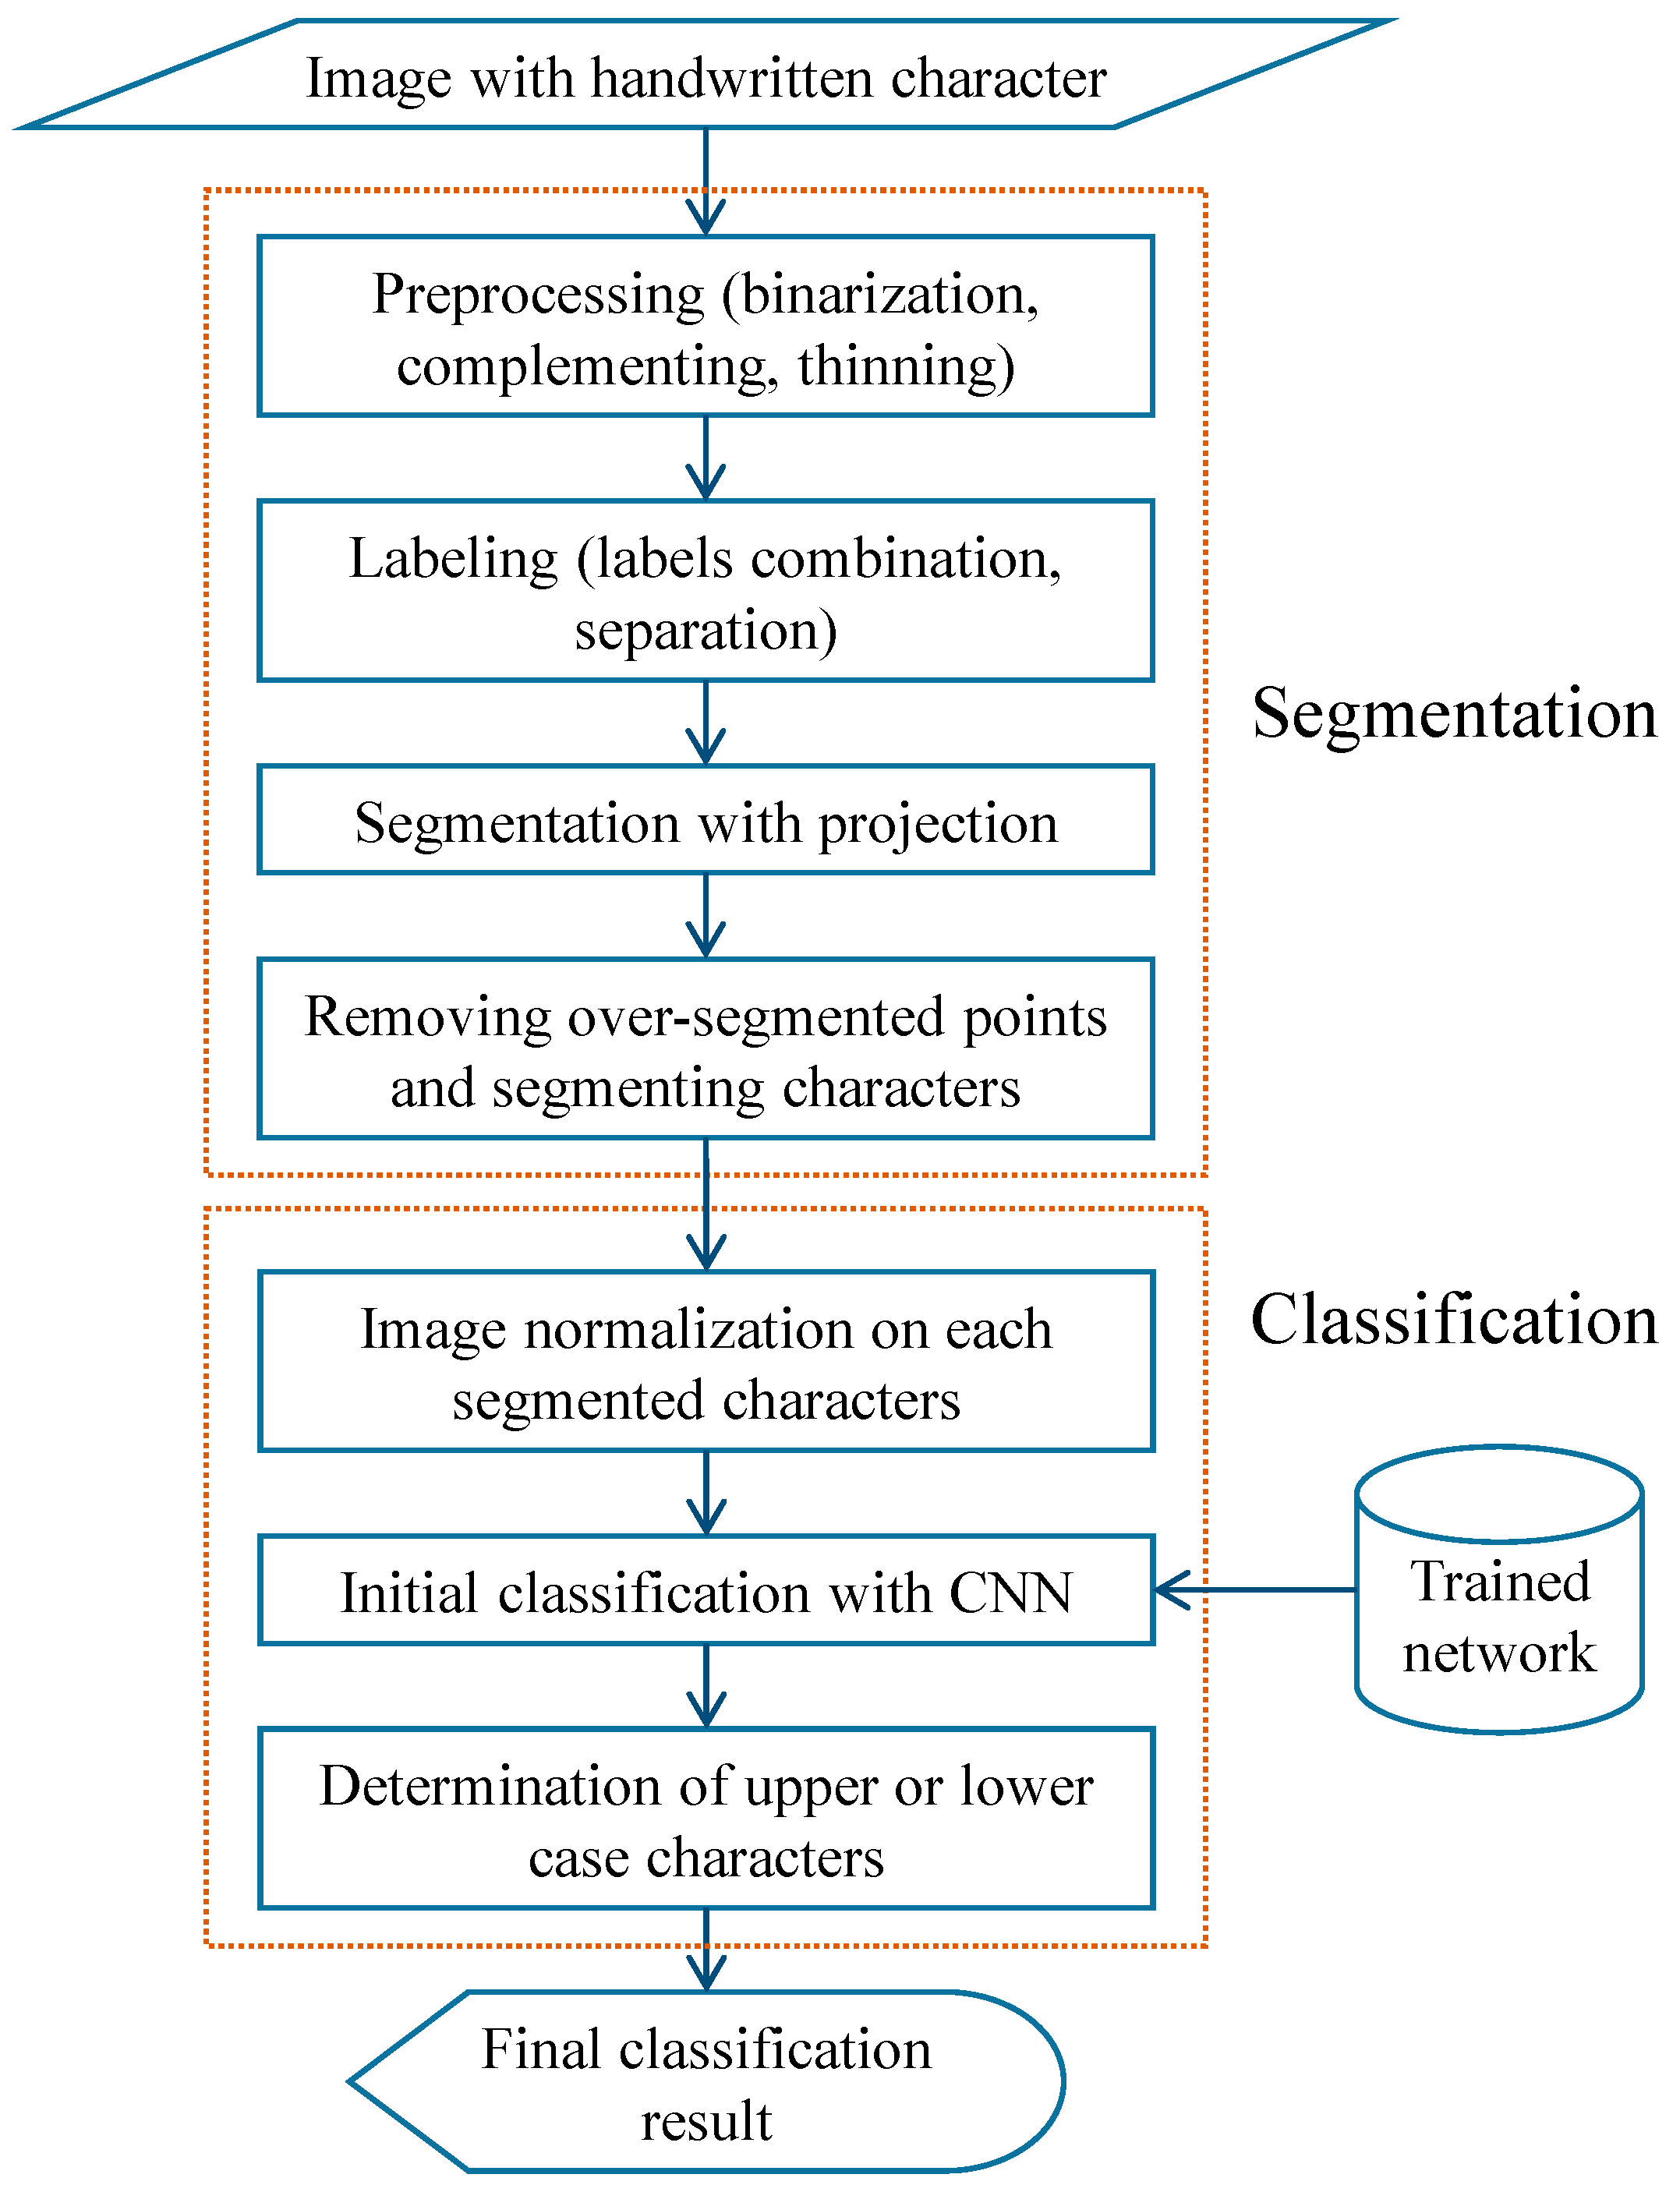